In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('./data/flight/flight_delays_train.csv')
test_df = pd.read_csv('./data/flight/flight_delays_test.csv')

In [3]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [5]:
train_df.shape,test_df.shape

((100000, 9), (100000, 8))

In [6]:
X_train, y_train = train_df[['Distance', 'DepTime']].values, train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [7]:
logit_pipe = Pipeline([('scaler', StandardScaler()),
                       ('logit', LogisticRegression(C=1, random_state=17, solver='liblinear'))])

In [8]:
logit_pipe.fit(X_train_part, y_train_part)
logit_valid_pred = logit_pipe.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6795691465352607

In [9]:
logit_pipe.fit(X_train, y_train)
logit_test_pred = logit_pipe.predict_proba(X_test)[:, 1]

pd.Series(logit_test_pred, 
          name='dep_delayed_15min').to_csv('./assignment10/logit_2feat.csv', 
                                           index_label='id', header=True)

## CATBOOST

In [105]:
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder

In [106]:
train_df = pd.read_csv('./data/flight/flight_delays_train.csv')
test_df = pd.read_csv('./data/flight/flight_delays_test.csv')

In [107]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [108]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [6]:
def cleanTime(x):
    if len(str(x))==4 and int(str(x)[:2])>=24:
        return str(int(str(x)[:2])-24)+str(x)[2:]
    elif len(str(x)) > 1:
        return str(x)
    else:
        return "0"+str(x)

In [7]:
def createtimefeatures(df):
    df["DepTime"] = df.DepTime.map(lambda x: cleanTime(x))
    df['hour'] = df.DepTime.map(lambda x: pd.to_datetime(x,format='%H%M').hour)
    df['min'] = df.DepTime.map(lambda x: pd.to_datetime(x,format='%H%M').minute)
    df['sin_hour'] = np.sin(2*np.pi*df['hour']/24)
    df['cos_hour'] = np.cos(2*np.pi*df['hour']/24)
    
    df.drop(["DepTime", "hour"], axis=1,inplace=True)
    return df
    

In [8]:
train_df = createtimefeatures(train_df)
test_df = createtimefeatures(test_df)

In [9]:
train_df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,min,sin_hour,cos_hour
0,c-8,c-21,c-7,AA,ATL,DFW,732,N,34,-0.965926,2.588190e-01
1,c-4,c-20,c-3,US,PIT,MCO,834,N,48,-0.707107,-7.071068e-01
2,c-9,c-2,c-5,XE,RDU,CLE,416,N,22,-0.500000,-8.660254e-01
3,c-11,c-25,c-6,OO,DEN,MEM,872,N,15,0.500000,-8.660254e-01
4,c-10,c-7,c-6,WN,MDW,OMA,423,Y,28,-1.000000,-1.836970e-16


In [10]:
test_df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,min,sin_hour,cos_hour
0,c-7,c-25,c-3,YV,MRY,PHX,598,15,1.000000,6.123234e-17
1,c-4,c-17,c-2,WN,LAS,HOU,1235,39,0.965926,-2.588190e-01
2,c-12,c-2,c-7,MQ,GSP,ORD,577,51,1.000000,6.123234e-17
3,c-3,c-25,c-7,WN,BWI,MHT,377,14,-0.866025,-5.000000e-01
4,c-6,c-6,c-3,UA,ORD,STL,258,5,-0.707107,-7.071068e-01


In [6]:
cat_features = ["Month", "DayofMonth", "DayOfWeek", "UniqueCarrier", "Origin", "Dest"]

In [7]:
df = pd.concat([train_df,test_df],axis=0)
le = LabelEncoder()
for col in cat_features:
    df[col] = le.fit_transform(df[col].astype(str))   

In [8]:
train_index = train_df.shape[0]

In [9]:
train_df = df.iloc[:train_index,:]
test_df = df.iloc[train_index:,:].drop('dep_delayed_15min',axis=1)

In [10]:
train_df.dep_delayed_15min.value_counts()

N    80956
Y    19044
Name: dep_delayed_15min, dtype: int64

In [136]:
# fig , (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# train_df.Month.value_counts().plot.bar(ax=ax1);
# test_df.Month.value_counts().plot.bar(ax=ax2);

In [139]:
def plot_bar(col_name):
    fig , (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    train_df[col_name].value_counts().plot.bar(ax=ax1);
    test_df[col_name].value_counts().plot.bar(ax=ax2);
    plt.title(col_name)
#     plt.figure()

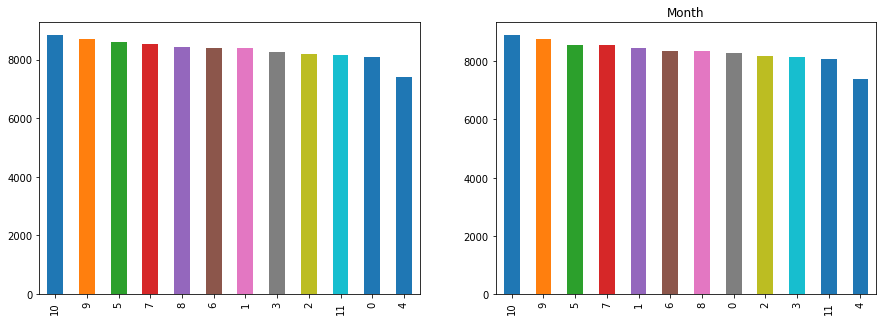

<Figure size 432x288 with 0 Axes>

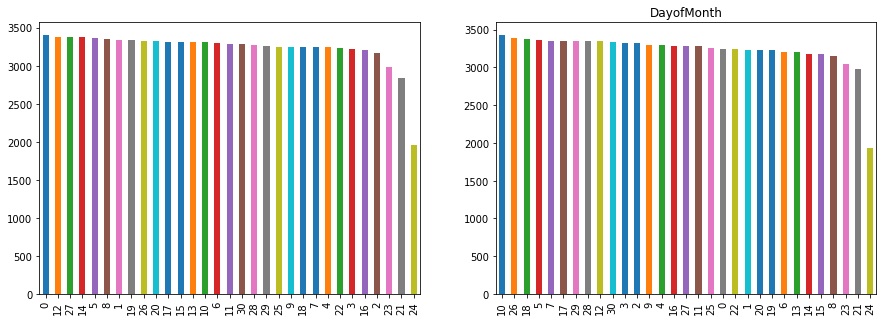

<Figure size 432x288 with 0 Axes>

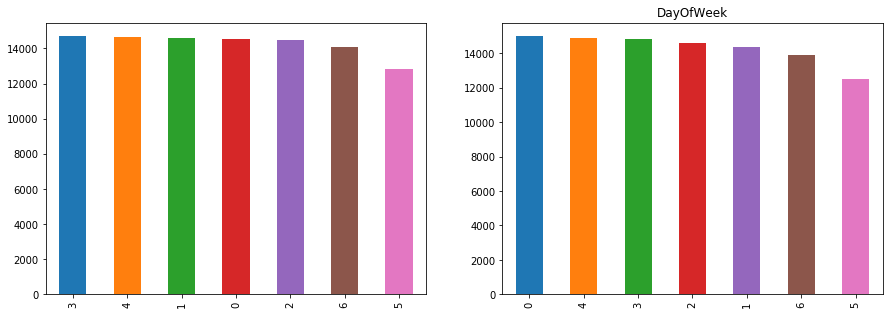

<Figure size 432x288 with 0 Axes>

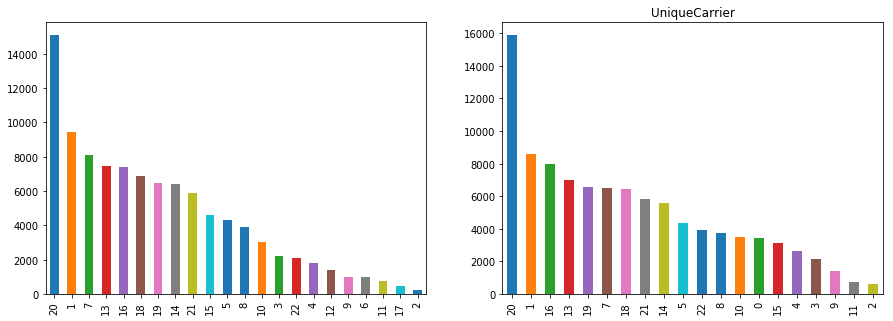

<Figure size 432x288 with 0 Axes>

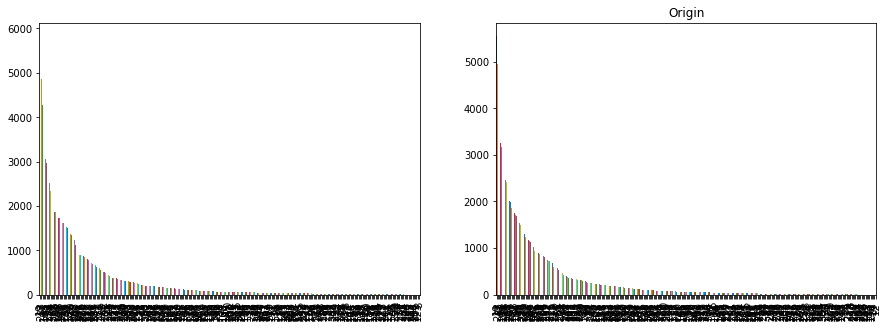

<Figure size 432x288 with 0 Axes>

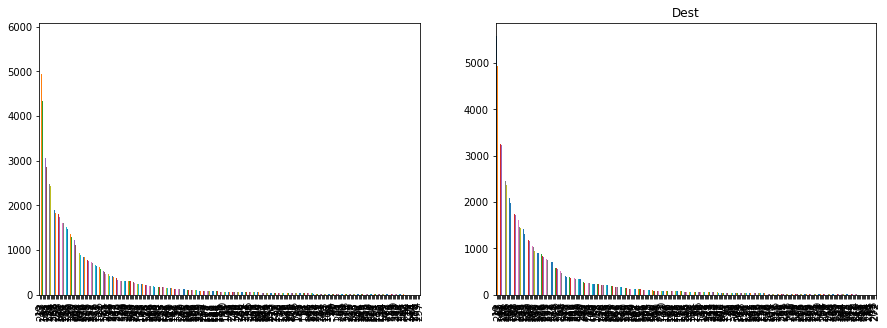

<Figure size 432x288 with 0 Axes>

In [140]:
for col_name in cat_features:
    plot_bar(col_name)

In [143]:
train_df.dep_delayed_15min.value_counts()

N    80956
Y    19044
Name: dep_delayed_15min, dtype: int64

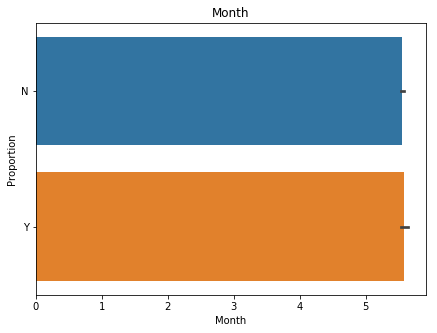

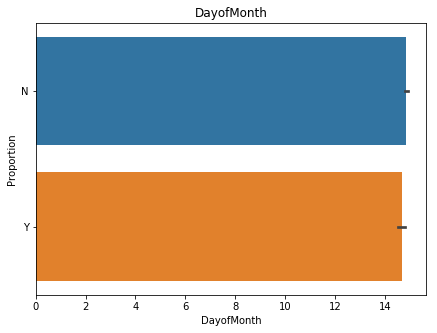

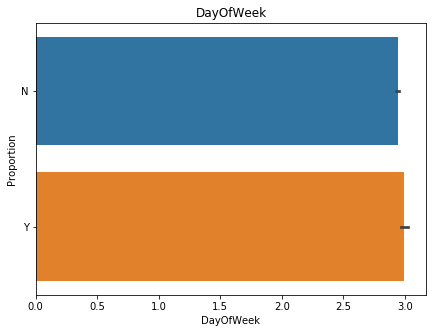

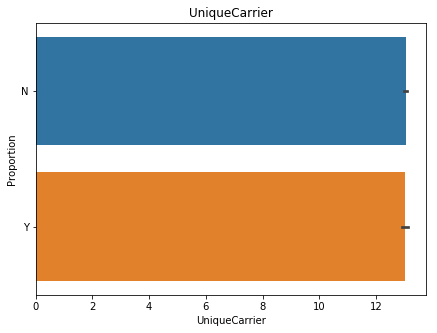

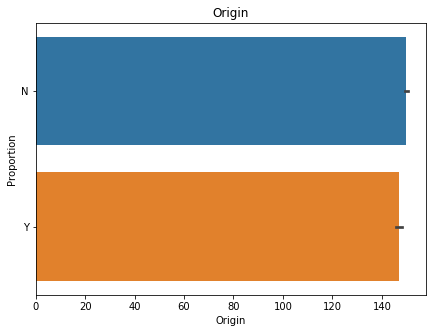

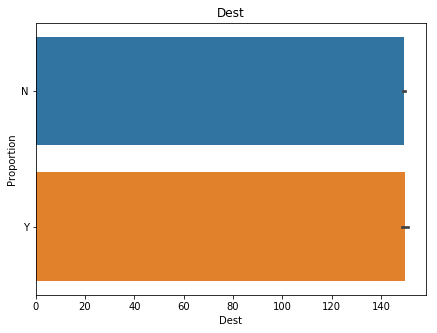

In [38]:
import seaborn as sns
for col_name in cat_features:
    plt.figure(figsize=(7, 5))
    ax = sns.barplot(x=col_name, y="dep_delayed_15min", data=train_df)
    ax.set(ylabel='Proportion')
    plt.title(col_name)
    plt.show()

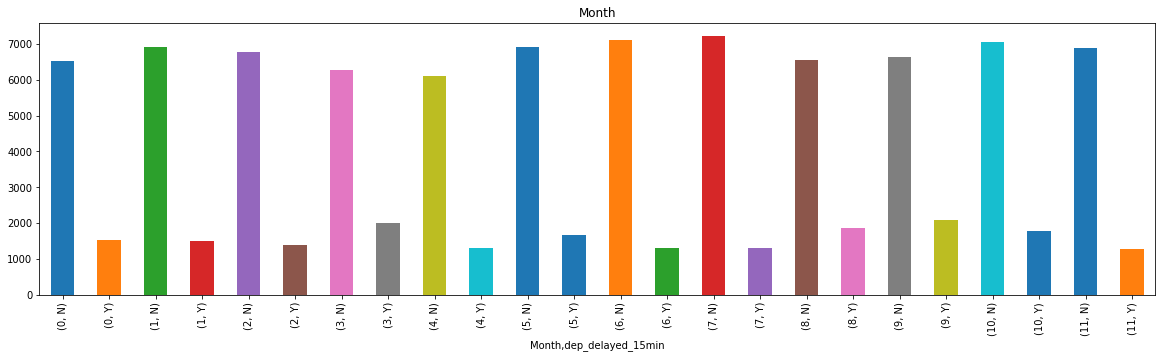

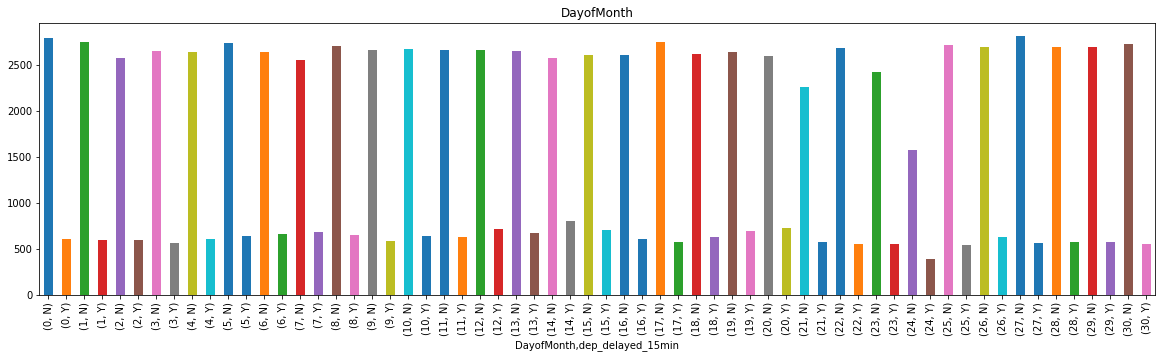

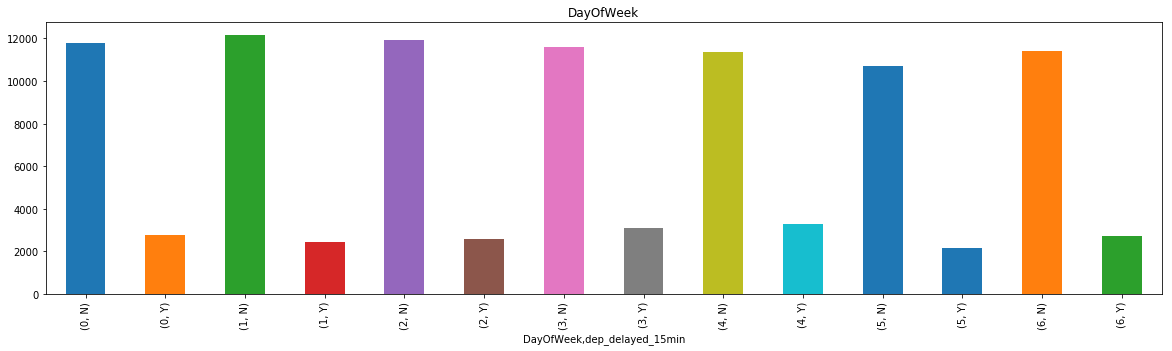

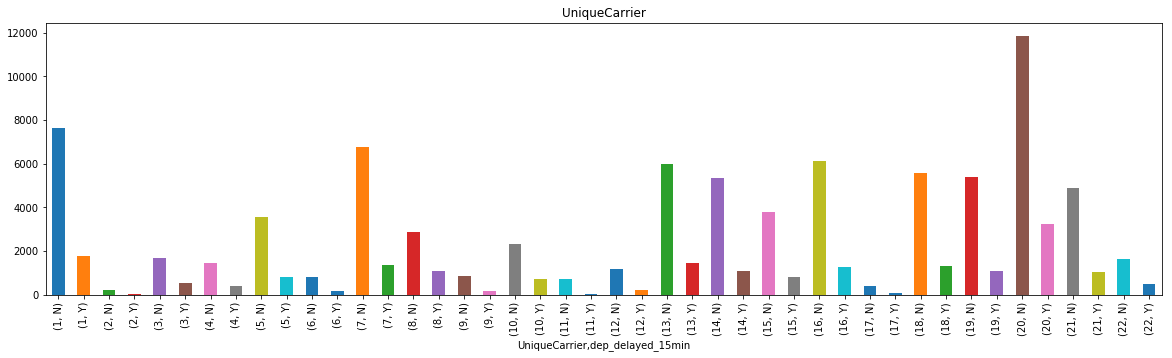

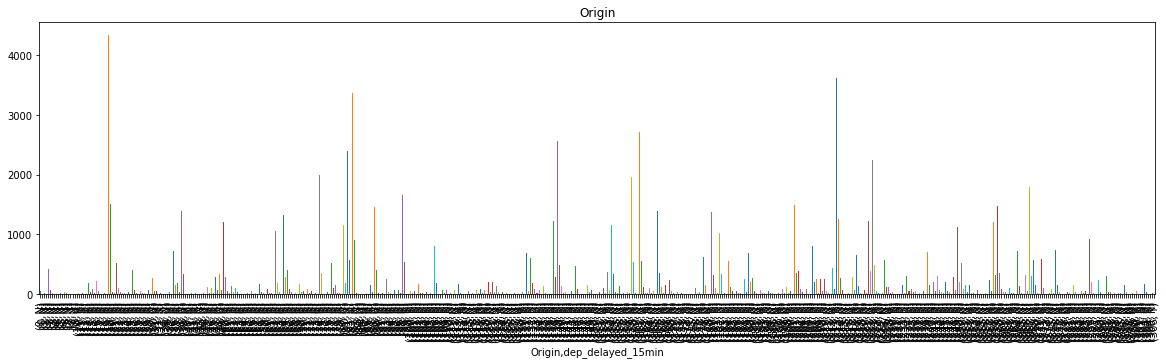

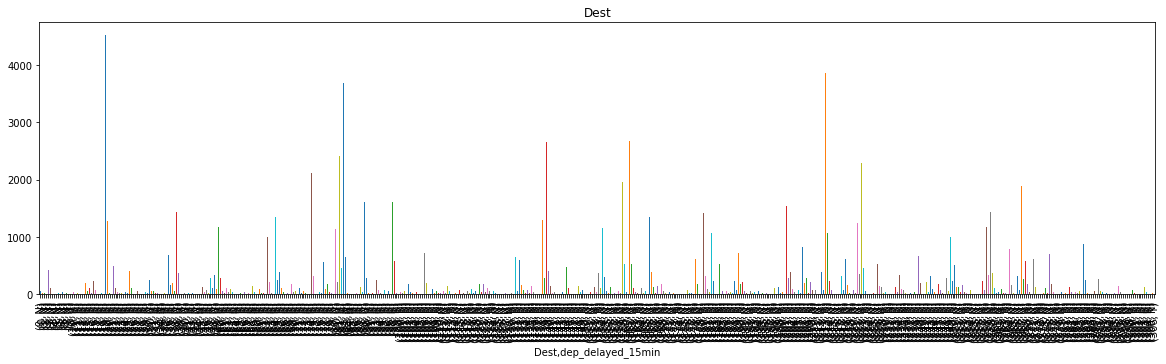

In [36]:
import seaborn as sns
for col_name in cat_features:
    plt.figure(figsize=(20, 5));
    train_df.groupby([col_name,'dep_delayed_15min'])['dep_delayed_15min'].count().plot.bar();
    plt.title(col_name)
    plt.show()

In [121]:
train_df.shape, test_df.shape

((100000, 11), (100000, 10))

In [39]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]
categorical_features_pos = column_index(train_df,cat_features)

In [40]:
categorical_features_pos

array([5, 1, 0, 7, 6, 3], dtype=int64)

In [124]:
train_df.columns.values

array(['DayOfWeek', 'DayofMonth', 'Dest', 'Distance', 'Month', 'Origin',
       'UniqueCarrier', 'cos_hour', 'dep_delayed_15min', 'min',
       'sin_hour'], dtype=object)

In [125]:
cat_features

['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']

In [126]:
X_train, y_train = train_df.drop('dep_delayed_15min',axis=1).values, train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

In [127]:
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [130]:
cb_model = CatBoostClassifier(iterations=1000, 
                              learning_rate=0.5,
                              depth=5,
                              eval_metric = 'AUC',
                              random_seed=23,
                              bagging_temperature=0.2,
                              od_type = 'Iter',
                              od_wait = 100                      
                             )

cb_model.fit(X_train_part, y_train_part,
             eval_set=(X_valid,y_valid),
             cat_features=categorical_features_pos,
             use_best_model=True,
             verbose=True)

0:	test: 0.6811226	best: 0.6811226 (0)	total: 168ms	remaining: 2m 48s
1:	test: 0.6962713	best: 0.6962713 (1)	total: 317ms	remaining: 2m 38s
2:	test: 0.6964555	best: 0.6964555 (2)	total: 463ms	remaining: 2m 33s
3:	test: 0.7107575	best: 0.7107575 (3)	total: 632ms	remaining: 2m 37s
4:	test: 0.7156715	best: 0.7156715 (4)	total: 817ms	remaining: 2m 42s
5:	test: 0.7202794	best: 0.7202794 (5)	total: 969ms	remaining: 2m 40s
6:	test: 0.7251882	best: 0.7251882 (6)	total: 1.17s	remaining: 2m 45s
7:	test: 0.7292658	best: 0.7292658 (7)	total: 1.32s	remaining: 2m 44s
8:	test: 0.7300465	best: 0.7300465 (8)	total: 1.48s	remaining: 2m 42s
9:	test: 0.7305970	best: 0.7305970 (9)	total: 1.59s	remaining: 2m 37s
10:	test: 0.7313790	best: 0.7313790 (10)	total: 1.75s	remaining: 2m 37s
11:	test: 0.7319568	best: 0.7319568 (11)	total: 1.87s	remaining: 2m 33s
12:	test: 0.7322073	best: 0.7322073 (12)	total: 2.03s	remaining: 2m 33s
13:	test: 0.7328695	best: 0.7328695 (13)	total: 2.19s	remaining: 2m 34s
14:	test: 0.

115:	test: 0.7487620	best: 0.7489593 (113)	total: 21.3s	remaining: 2m 42s
116:	test: 0.7489552	best: 0.7489593 (113)	total: 21.5s	remaining: 2m 42s
117:	test: 0.7487359	best: 0.7489593 (113)	total: 21.7s	remaining: 2m 42s
118:	test: 0.7486385	best: 0.7489593 (113)	total: 21.9s	remaining: 2m 42s
119:	test: 0.7492771	best: 0.7492771 (119)	total: 22.2s	remaining: 2m 42s
120:	test: 0.7492676	best: 0.7492771 (119)	total: 22.5s	remaining: 2m 43s
121:	test: 0.7491808	best: 0.7492771 (119)	total: 22.7s	remaining: 2m 43s
122:	test: 0.7491123	best: 0.7492771 (119)	total: 22.9s	remaining: 2m 43s
123:	test: 0.7493815	best: 0.7493815 (123)	total: 23.1s	remaining: 2m 43s
124:	test: 0.7494222	best: 0.7494222 (124)	total: 23.4s	remaining: 2m 43s
125:	test: 0.7491789	best: 0.7494222 (124)	total: 23.6s	remaining: 2m 43s
126:	test: 0.7491764	best: 0.7494222 (124)	total: 23.9s	remaining: 2m 44s
127:	test: 0.7491412	best: 0.7494222 (124)	total: 24.3s	remaining: 2m 45s
128:	test: 0.7491006	best: 0.7494222 (

228:	test: 0.7485902	best: 0.7495468 (148)	total: 50.9s	remaining: 2m 51s
229:	test: 0.7485235	best: 0.7495468 (148)	total: 51.1s	remaining: 2m 50s
230:	test: 0.7486674	best: 0.7495468 (148)	total: 51.2s	remaining: 2m 50s
231:	test: 0.7487382	best: 0.7495468 (148)	total: 51.4s	remaining: 2m 49s
232:	test: 0.7488139	best: 0.7495468 (148)	total: 51.5s	remaining: 2m 49s
233:	test: 0.7488048	best: 0.7495468 (148)	total: 51.7s	remaining: 2m 49s
234:	test: 0.7489207	best: 0.7495468 (148)	total: 51.9s	remaining: 2m 48s
235:	test: 0.7488378	best: 0.7495468 (148)	total: 52s	remaining: 2m 48s
236:	test: 0.7486167	best: 0.7495468 (148)	total: 52.2s	remaining: 2m 48s
237:	test: 0.7487151	best: 0.7495468 (148)	total: 52.4s	remaining: 2m 47s
238:	test: 0.7487687	best: 0.7495468 (148)	total: 52.6s	remaining: 2m 47s
239:	test: 0.7487490	best: 0.7495468 (148)	total: 52.7s	remaining: 2m 46s
240:	test: 0.7487262	best: 0.7495468 (148)	total: 52.9s	remaining: 2m 46s
241:	test: 0.7487063	best: 0.7495468 (14

In [49]:
cb_model = CatBoostClassifier(iterations=500, 
                              learning_rate=0.5,
                              depth=2,
                              eval_metric = 'AUC',
                              random_seed=23,
                              bagging_temperature=0.2,
                              od_type = 'Iter',
                              od_wait = 100                      
                             )

cb_model.fit(X_train_part, y_train_part,
             eval_set=(X_valid,y_valid),
             cat_features=categorical_features_pos,
             use_best_model=True,
             verbose=True)

0:	test: 0.6486642	best: 0.6486642 (0)	total: 74.5ms	remaining: 37.2s
1:	test: 0.6738999	best: 0.6738999 (1)	total: 149ms	remaining: 37.2s
2:	test: 0.6754467	best: 0.6754467 (2)	total: 229ms	remaining: 37.9s
3:	test: 0.6882590	best: 0.6882590 (3)	total: 320ms	remaining: 39.7s
4:	test: 0.6944654	best: 0.6944654 (4)	total: 399ms	remaining: 39.5s
5:	test: 0.7009042	best: 0.7009042 (5)	total: 488ms	remaining: 40.2s
6:	test: 0.7017849	best: 0.7017849 (6)	total: 586ms	remaining: 41.3s
7:	test: 0.7044377	best: 0.7044377 (7)	total: 656ms	remaining: 40.4s
8:	test: 0.7063063	best: 0.7063063 (8)	total: 755ms	remaining: 41.2s
9:	test: 0.7084440	best: 0.7084440 (9)	total: 840ms	remaining: 41.2s
10:	test: 0.7089441	best: 0.7089441 (10)	total: 910ms	remaining: 40.5s
11:	test: 0.7154557	best: 0.7154557 (11)	total: 997ms	remaining: 40.5s
12:	test: 0.7172732	best: 0.7172732 (12)	total: 1.08s	remaining: 40.6s
13:	test: 0.7183705	best: 0.7183705 (13)	total: 1.18s	remaining: 40.9s
14:	test: 0.7191196	best:

116:	test: 0.7335099	best: 0.7335099 (116)	total: 9.75s	remaining: 31.9s
117:	test: 0.7335128	best: 0.7335128 (117)	total: 9.81s	remaining: 31.8s
118:	test: 0.7335216	best: 0.7335216 (118)	total: 9.88s	remaining: 31.6s
119:	test: 0.7334524	best: 0.7335216 (118)	total: 9.93s	remaining: 31.5s
120:	test: 0.7335957	best: 0.7335957 (120)	total: 10s	remaining: 31.3s
121:	test: 0.7336287	best: 0.7336287 (121)	total: 10.1s	remaining: 31.2s
122:	test: 0.7340746	best: 0.7340746 (122)	total: 10.1s	remaining: 31.1s
123:	test: 0.7340880	best: 0.7340880 (123)	total: 10.2s	remaining: 30.9s
124:	test: 0.7340484	best: 0.7340880 (123)	total: 10.2s	remaining: 30.7s
125:	test: 0.7341723	best: 0.7341723 (125)	total: 10.3s	remaining: 30.6s
126:	test: 0.7341802	best: 0.7341802 (126)	total: 10.4s	remaining: 30.5s
127:	test: 0.7342551	best: 0.7342551 (127)	total: 10.4s	remaining: 30.3s
128:	test: 0.7343987	best: 0.7343987 (128)	total: 10.5s	remaining: 30.2s
129:	test: 0.7343539	best: 0.7343987 (128)	total: 10.

229:	test: 0.7378400	best: 0.7378512 (228)	total: 17.8s	remaining: 20.9s
230:	test: 0.7378424	best: 0.7378512 (228)	total: 18s	remaining: 20.9s
231:	test: 0.7378535	best: 0.7378535 (231)	total: 18s	remaining: 20.8s
232:	test: 0.7378800	best: 0.7378800 (232)	total: 18.1s	remaining: 20.7s
233:	test: 0.7378800	best: 0.7378800 (232)	total: 18.2s	remaining: 20.7s
234:	test: 0.7378522	best: 0.7378800 (232)	total: 18.3s	remaining: 20.6s
235:	test: 0.7380362	best: 0.7380362 (235)	total: 18.4s	remaining: 20.6s
236:	test: 0.7380342	best: 0.7380362 (235)	total: 18.4s	remaining: 20.5s
237:	test: 0.7380365	best: 0.7380365 (237)	total: 18.5s	remaining: 20.4s
238:	test: 0.7381246	best: 0.7381246 (238)	total: 18.6s	remaining: 20.3s
239:	test: 0.7384955	best: 0.7384955 (239)	total: 18.7s	remaining: 20.3s
240:	test: 0.7384902	best: 0.7384955 (239)	total: 18.8s	remaining: 20.2s
241:	test: 0.7385316	best: 0.7385316 (241)	total: 19s	remaining: 20.2s
242:	test: 0.7385353	best: 0.7385353 (242)	total: 19.1s	r

342:	test: 0.7398885	best: 0.7399085 (339)	total: 27.4s	remaining: 12.5s
343:	test: 0.7398528	best: 0.7399085 (339)	total: 27.5s	remaining: 12.5s
344:	test: 0.7399149	best: 0.7399149 (344)	total: 27.5s	remaining: 12.4s
345:	test: 0.7398776	best: 0.7399149 (344)	total: 27.6s	remaining: 12.3s
346:	test: 0.7398151	best: 0.7399149 (344)	total: 27.7s	remaining: 12.2s
347:	test: 0.7398150	best: 0.7399149 (344)	total: 27.8s	remaining: 12.1s
348:	test: 0.7398150	best: 0.7399149 (344)	total: 27.8s	remaining: 12s
349:	test: 0.7397902	best: 0.7399149 (344)	total: 27.9s	remaining: 12s
350:	test: 0.7397263	best: 0.7399149 (344)	total: 28s	remaining: 11.9s
351:	test: 0.7397393	best: 0.7399149 (344)	total: 28s	remaining: 11.8s
352:	test: 0.7397401	best: 0.7399149 (344)	total: 28.1s	remaining: 11.7s
353:	test: 0.7397372	best: 0.7399149 (344)	total: 28.2s	remaining: 11.6s
354:	test: 0.7396757	best: 0.7399149 (344)	total: 28.3s	remaining: 11.6s
355:	test: 0.7396733	best: 0.7399149 (344)	total: 28.4s	rem

455:	test: 0.7412126	best: 0.7412131 (454)	total: 35.5s	remaining: 3.42s
456:	test: 0.7412676	best: 0.7412676 (456)	total: 35.5s	remaining: 3.34s
457:	test: 0.7412646	best: 0.7412676 (456)	total: 35.6s	remaining: 3.26s
458:	test: 0.7412657	best: 0.7412676 (456)	total: 35.7s	remaining: 3.18s
459:	test: 0.7413167	best: 0.7413167 (459)	total: 35.7s	remaining: 3.1s
460:	test: 0.7414132	best: 0.7414132 (460)	total: 35.8s	remaining: 3.03s
461:	test: 0.7414121	best: 0.7414132 (460)	total: 35.8s	remaining: 2.95s
462:	test: 0.7414128	best: 0.7414132 (460)	total: 35.9s	remaining: 2.87s
463:	test: 0.7414124	best: 0.7414132 (460)	total: 36s	remaining: 2.79s
464:	test: 0.7414124	best: 0.7414132 (460)	total: 36s	remaining: 2.71s
465:	test: 0.7413617	best: 0.7414132 (460)	total: 36.1s	remaining: 2.63s
466:	test: 0.7413511	best: 0.7414132 (460)	total: 36.2s	remaining: 2.56s
467:	test: 0.7413494	best: 0.7414132 (460)	total: 36.2s	remaining: 2.48s
468:	test: 0.7413498	best: 0.7414132 (460)	total: 36.3s	

In [107]:
cb_model = CatBoostClassifier(iterations=1000, 
                              learning_rate=0.5,
                              depth=5,
                              eval_metric = 'AUC',
                              random_seed=23,
                              bagging_temperature=0.2,
                              od_type = 'Iter',
                              od_wait = 100                      
                             )

cb_model.fit(X_train_part, y_train_part,
             eval_set=(X_valid,y_valid),
             cat_features=categorical_features_pos,
             use_best_model=True,
             verbose=True)

0:	test: 0.6750024	best: 0.6750024 (0)	total: 207ms	remaining: 3m 26s
1:	test: 0.6936651	best: 0.6936651 (1)	total: 378ms	remaining: 3m 8s
2:	test: 0.6985673	best: 0.6985673 (2)	total: 522ms	remaining: 2m 53s
3:	test: 0.7104091	best: 0.7104091 (3)	total: 686ms	remaining: 2m 50s
4:	test: 0.7143250	best: 0.7143250 (4)	total: 853ms	remaining: 2m 49s
5:	test: 0.7162392	best: 0.7162392 (5)	total: 1.04s	remaining: 2m 52s
6:	test: 0.7193957	best: 0.7193957 (6)	total: 1.21s	remaining: 2m 51s
7:	test: 0.7266522	best: 0.7266522 (7)	total: 1.37s	remaining: 2m 50s
8:	test: 0.7291893	best: 0.7291893 (8)	total: 1.51s	remaining: 2m 46s
9:	test: 0.7332430	best: 0.7332430 (9)	total: 1.7s	remaining: 2m 48s
10:	test: 0.7335568	best: 0.7335568 (10)	total: 1.83s	remaining: 2m 44s
11:	test: 0.7343266	best: 0.7343266 (11)	total: 1.97s	remaining: 2m 42s
12:	test: 0.7351141	best: 0.7351141 (12)	total: 2.11s	remaining: 2m 40s
13:	test: 0.7353930	best: 0.7353930 (13)	total: 2.25s	remaining: 2m 38s
14:	test: 0.73

115:	test: 0.7493421	best: 0.7502557 (93)	total: 17.9s	remaining: 2m 16s
116:	test: 0.7493655	best: 0.7502557 (93)	total: 18.1s	remaining: 2m 16s
117:	test: 0.7493125	best: 0.7502557 (93)	total: 18.2s	remaining: 2m 16s
118:	test: 0.7492437	best: 0.7502557 (93)	total: 18.3s	remaining: 2m 15s
119:	test: 0.7492365	best: 0.7502557 (93)	total: 18.5s	remaining: 2m 15s
120:	test: 0.7490650	best: 0.7502557 (93)	total: 18.6s	remaining: 2m 15s
121:	test: 0.7493390	best: 0.7502557 (93)	total: 18.8s	remaining: 2m 15s
122:	test: 0.7492755	best: 0.7502557 (93)	total: 18.9s	remaining: 2m 14s
123:	test: 0.7492248	best: 0.7502557 (93)	total: 19s	remaining: 2m 14s
124:	test: 0.7495002	best: 0.7502557 (93)	total: 19.2s	remaining: 2m 14s
125:	test: 0.7495977	best: 0.7502557 (93)	total: 19.3s	remaining: 2m 14s
126:	test: 0.7496902	best: 0.7502557 (93)	total: 19.5s	remaining: 2m 13s
127:	test: 0.7496825	best: 0.7502557 (93)	total: 19.6s	remaining: 2m 13s
128:	test: 0.7496758	best: 0.7502557 (93)	total: 19.8

229:	test: 0.7509521	best: 0.7513534 (192)	total: 33.3s	remaining: 1m 51s
230:	test: 0.7512933	best: 0.7513534 (192)	total: 33.4s	remaining: 1m 51s
231:	test: 0.7512625	best: 0.7513534 (192)	total: 33.6s	remaining: 1m 51s
232:	test: 0.7512353	best: 0.7513534 (192)	total: 33.7s	remaining: 1m 50s
233:	test: 0.7511956	best: 0.7513534 (192)	total: 33.8s	remaining: 1m 50s
234:	test: 0.7512713	best: 0.7513534 (192)	total: 34s	remaining: 1m 50s
235:	test: 0.7512854	best: 0.7513534 (192)	total: 34.1s	remaining: 1m 50s
236:	test: 0.7513256	best: 0.7513534 (192)	total: 34.2s	remaining: 1m 50s
237:	test: 0.7513287	best: 0.7513534 (192)	total: 34.4s	remaining: 1m 50s
238:	test: 0.7513242	best: 0.7513534 (192)	total: 34.5s	remaining: 1m 49s
239:	test: 0.7512517	best: 0.7513534 (192)	total: 34.7s	remaining: 1m 49s
240:	test: 0.7510446	best: 0.7513534 (192)	total: 34.8s	remaining: 1m 49s
241:	test: 0.7509936	best: 0.7513534 (192)	total: 34.9s	remaining: 1m 49s
242:	test: 0.7511186	best: 0.7513534 (19

342:	test: 0.7498549	best: 0.7516011 (275)	total: 48.6s	remaining: 1m 33s
343:	test: 0.7498580	best: 0.7516011 (275)	total: 48.8s	remaining: 1m 32s
344:	test: 0.7497818	best: 0.7516011 (275)	total: 48.9s	remaining: 1m 32s
345:	test: 0.7498304	best: 0.7516011 (275)	total: 49.1s	remaining: 1m 32s
346:	test: 0.7498263	best: 0.7516011 (275)	total: 49.2s	remaining: 1m 32s
347:	test: 0.7496724	best: 0.7516011 (275)	total: 49.4s	remaining: 1m 32s
348:	test: 0.7495635	best: 0.7516011 (275)	total: 49.5s	remaining: 1m 32s
349:	test: 0.7495281	best: 0.7516011 (275)	total: 49.7s	remaining: 1m 32s
350:	test: 0.7496003	best: 0.7516011 (275)	total: 49.8s	remaining: 1m 32s
351:	test: 0.7495592	best: 0.7516011 (275)	total: 49.9s	remaining: 1m 31s
352:	test: 0.7497074	best: 0.7516011 (275)	total: 50.1s	remaining: 1m 31s
353:	test: 0.7497089	best: 0.7516011 (275)	total: 50.2s	remaining: 1m 31s
354:	test: 0.7497177	best: 0.7516011 (275)	total: 50.4s	remaining: 1m 31s
355:	test: 0.7497171	best: 0.7516011 (

In [51]:
# cb_pipe = Pipeline([('scaler', StandardScaler()),
#                        ('logit', cb_model)])

# cb_model.fit(X_train_part, y_train_part,
#              eval_set=(X_valid,y_valid),
#              cat_features=categorical_features_pos,
#              use_best_model=True,
#              verbose=True)

#### Full Data

In [131]:
cb_model = CatBoostClassifier(iterations=100, random_seed=23,depth=5, learning_rate=0.5, bagging_temperature=0.2)
cb_model.fit(X_train, y_train, cat_features=categorical_features_pos)

0:	learn: 0.4983808	total: 159ms	remaining: 15.7s
1:	learn: 0.4580350	total: 317ms	remaining: 15.6s
2:	learn: 0.4484435	total: 484ms	remaining: 15.7s
3:	learn: 0.4438009	total: 641ms	remaining: 15.4s
4:	learn: 0.4369245	total: 832ms	remaining: 15.8s
5:	learn: 0.4347794	total: 1.02s	remaining: 16s
6:	learn: 0.4327180	total: 1.17s	remaining: 15.5s
7:	learn: 0.4315343	total: 1.31s	remaining: 15.1s
8:	learn: 0.4309061	total: 1.44s	remaining: 14.5s
9:	learn: 0.4281697	total: 1.61s	remaining: 14.5s
10:	learn: 0.4274760	total: 1.75s	remaining: 14.2s
11:	learn: 0.4266235	total: 1.9s	remaining: 13.9s
12:	learn: 0.4259952	total: 2.04s	remaining: 13.7s
13:	learn: 0.4256383	total: 2.22s	remaining: 13.6s
14:	learn: 0.4244808	total: 2.38s	remaining: 13.5s
15:	learn: 0.4236119	total: 2.55s	remaining: 13.4s
16:	learn: 0.4225812	total: 2.69s	remaining: 13.2s
17:	learn: 0.4223410	total: 2.86s	remaining: 13s
18:	learn: 0.4221662	total: 3s	remaining: 12.8s
19:	learn: 0.4219692	total: 3.15s	remaining: 12.6

In [132]:
X_test = test_df.values
catboost_test_pred = cb_model.predict_proba(X_test)[:, 1]

In [133]:
pd.Series(catboost_test_pred, 
          name='dep_delayed_15min').to_csv('./assignment10/catboost_test_pred5.csv', 
                                           index_label='id', header=True)

## LightGBM

In [11]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

In [12]:
train_df.head()

,DayOfWeek,DayofMonth,DepTime,Dest,Distance,Month,Origin,UniqueCarrier,dep_delayed_15min
0,6,13,1934,82,732,10,19,1,N
1,2,12,1548,180,834,6,226,19,N
2,4,11,1422,62,416,11,239,21,N
3,5,17,1015,184,872,2,81,16,N
4,5,28,1828,210,423,1,182,20,Y


In [13]:
X_train, y_train = train_df.drop('dep_delayed_15min',axis=1), train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})

In [14]:
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [15]:
%%time
lgb_clf = LGBMClassifier(random_state=17)
lgb_clf.fit(X_train_part, y_train_part)

Wall time: 600 ms


In [16]:
roc_auc_score(y_valid,lgb_clf.predict_proba(X_valid)[:,1])

0.7304402744059957

In [55]:
gridParams = {
    'num_leaves':[15],
    'reg_alpha' : [1],
    'max_depth':[5],
    'reg_lambda':[1.2]
    }

In [56]:
mdl = LGBMClassifier(boosting_type= 'gbdt', objective = 'binary', random_state=17,
                    categorical_feature=categorical_features_pos)
grid_searcher = GridSearchCV(estimator=mdl, param_grid=gridParams, cv=5, verbose=1, n_jobs=-1,scoring='roc_auc')
grid_searcher.fit(X_train_part, y_train_part)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   14.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=array([5, 1, 0, 7, 6, 3], dtype=int64),
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0...0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'num_leaves': [15], 'reg_alpha': [1], 'max_depth': [5], 'reg_lambda': [0.8, 1, 1.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [57]:
grid_searcher.best_params_, grid_searcher.best_score_

({'max_depth': 5, 'num_leaves': 15, 'reg_alpha': 1, 'reg_lambda': 1.2},
 0.7320770482400312)

In [58]:
roc_auc_score(y_valid, grid_searcher.predict_proba(X_valid)[:,1])

0.7257431690015308

In [42]:
# roc_auc_score(y_valid, grid_searcher.predict_proba(X_valid)[:,1]) #0.7376782267086497 #0.7388821160068774

0.7376782267086497

In [59]:
num_iterations = 300
lgb_clf2 = LGBMClassifier(boosting_type= 'gbdt', objective = 'binary',
                          random_state=17, reg_lambda=1.2,num_leaves=15, max_depth=5,
                          n_estimators=num_iterations, reg_alpha=1,
                          n_jobs=-1,categorical_feature=categorical_features_pos)

param_grid2 = {'learning_rate': np.logspace(-3, 0, 5)}
grid_searcher2 = GridSearchCV(estimator=lgb_clf2, param_grid=param_grid2,
                               cv=5, verbose=1, n_jobs=4)
grid_searcher2.fit(X_train_part, y_train_part)

print(grid_searcher2.best_params_, grid_searcher2.best_score_)
print(roc_auc_score(y_valid, grid_searcher2.predict_proba(X_valid)[:,1]))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   47.3s finished


{'learning_rate': 0.03162277660168379} 0.8190285714285714
0.7261326863863864


In [33]:
# print(roc_auc_score(y_valid, grid_searcher2.predict_proba(X_valid)[:,1])) 
#0.739446919116459#0.7403669433951042

In [30]:
final_lgb  = LGBMClassifier(boosting_type= 'gbdt', objective = 'binary',
                          random_state=17, reg_lambda=1.2,num_leaves=127, max_depth=-1,
                          n_estimators=200, reg_alpha=1.2, learning_rate = grid_searcher2.best_params_['learning_rate'],
                          feature_fraction=0.5, bagging_fraction= 0.5, bagging_freq= 20,
                          n_jobs=-1)

In [31]:
final_lgb.fit(X_train_part,y_train_part)
roc_auc_score(y_valid, final_lgb.predict_proba(X_valid)[:,1])

0.7133886173630758

In [26]:
final_lgb.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.046415888336127774,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=127,
        objective='binary', random_state=17, reg_alpha=1.2, reg_lambda=1.2,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [27]:
X_test = test_df.values
lightboost_test_pred = final_lgb.predict_proba(X_test)[:, 1]

In [28]:
pd.Series(lightboost_test_pred, 
          name='dep_delayed_15min').to_csv('./assignment10/lightboost_test_pred7.csv', 
                                           index_label='id', header=True)

In [75]:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

In [76]:
# model = lightgbm.train(parameters,train_data, valid_sets=test_data, num_boost_round=5000,early_stopping_rounds=100)

[1]	valid_0's auc: 0.575089
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.690398
[3]	valid_0's auc: 0.682391
[4]	valid_0's auc: 0.695891
[5]	valid_0's auc: 0.693494
[6]	valid_0's auc: 0.697842
[7]	valid_0's auc: 0.696192
[8]	valid_0's auc: 0.698675
[9]	valid_0's auc: 0.697879
[10]	valid_0's auc: 0.699728
[11]	valid_0's auc: 0.698801
[12]	valid_0's auc: 0.700582
[13]	valid_0's auc: 0.700481
[14]	valid_0's auc: 0.701637
[15]	valid_0's auc: 0.701174
[16]	valid_0's auc: 0.702071
[17]	valid_0's auc: 0.701822
[18]	valid_0's auc: 0.70281
[19]	valid_0's auc: 0.702696
[20]	valid_0's auc: 0.703447
[21]	valid_0's auc: 0.703797
[22]	valid_0's auc: 0.705342
[23]	valid_0's auc: 0.705584
[24]	valid_0's auc: 0.706815
[25]	valid_0's auc: 0.706975
[26]	valid_0's auc: 0.707903
[27]	valid_0's auc: 0.707915
[28]	valid_0's auc: 0.708411
[29]	valid_0's auc: 0.708203
[30]	valid_0's auc: 0.708579
[31]	valid_0's auc: 0.708691
[32]	valid_0's auc: 0.709217
[33]	valid_0's auc:

## Xgboost

In [77]:
import xgboost as xgb

In [80]:
gbm = xgb.XGBClassifier(max_depth=4, n_estimators=500, learning_rate=0.1,silent=False,n_jobs=-1).fit(X_train_part,y_train_part)
roc_auc_score(y_valid,gbm.predict(X_valid))

[22:33:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[22:33:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[22:33:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[22:33:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[22:33:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[22:33:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[22:33:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[22:33:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[22:33:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[22:33:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[22:33:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22:33:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[22:33:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[22:33:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22:33:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[22:33:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[22:33:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[22:33:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[22:33:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[22:33:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[22:33:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[22:33:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[22:33:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[22:33:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[22:33:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:33:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[22:33:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[22:33:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

0.5529884150531227

### Ensembling

In [108]:
logistic  = pd.read_csv('./assignment10/logit_2feat.csv',index_col='id')
catboost = pd.read_csv('./assignment10/catboost_test_pred.csv',index_col='id')

In [109]:
logistic.head()

,dep_delayed_15min
id,
0,0.070382
1,0.082511
2,0.073706
3,0.231343
4,0.205625


In [110]:
catboost.head()

,dep_delayed_15min
id,
0,0.025692
1,0.053554
2,0.039986
3,0.257235
4,0.263916


In [111]:
catboost.dep_delayed_15min.corr(logistic.dep_delayed_15min)

0.7125216675252072

In [102]:
catboost['dep_delayed_15min'] = logistic.dep_delayed_15min*0.2 + catboost.dep_delayed_15min*0.8

In [103]:
catboost.head()

,dep_delayed_15min
id,
0,0.034630
1,0.059345
2,0.046730
3,0.252056
4,0.252258


In [94]:
catboost.to_csv('./assignment10/ensemble_test_pred4.csv', 
                                           index_label='id', header=True)

## ensembling

In [106]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor